This notebook makes projections for the Gecco telescope. Currently it uses the same target region as COMPTEL and a background model derived from COMPTEL and EGRET data (see eq. 14 [here](https://arxiv.org/pdf/1504.04024)).

We need to think about what targets and background models make sense. We should probably do projections for the Galactic Center, dSphs, and ROIs of other experiments. One issue with dSph projections is that Gecco's angular resolution is quite poor ($\sim 6^\circ$), so we'll need to account for this properly.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

In [2]:
from hazma.gamma_ray_parameters import egret_diffuse, fermi_diffuse, comptel_diffuse
from hazma.gamma_ray_parameters import A_eff_comptel, A_eff_egret, A_eff_fermi, energy_res_comptel
from hazma.gamma_ray_parameters import (
    gc_target, gc_bg_model, draco_target, default_bg_model
)
from hazma.gamma_ray_parameters import (
    A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam
)
from hazma.gamma_ray_parameters import (
    A_eff_gecco, energy_res_gecco, energy_res_gecco_large
)

T_obs_gecco = 1e6  # s. This is a VERY short time!

# Effective areas

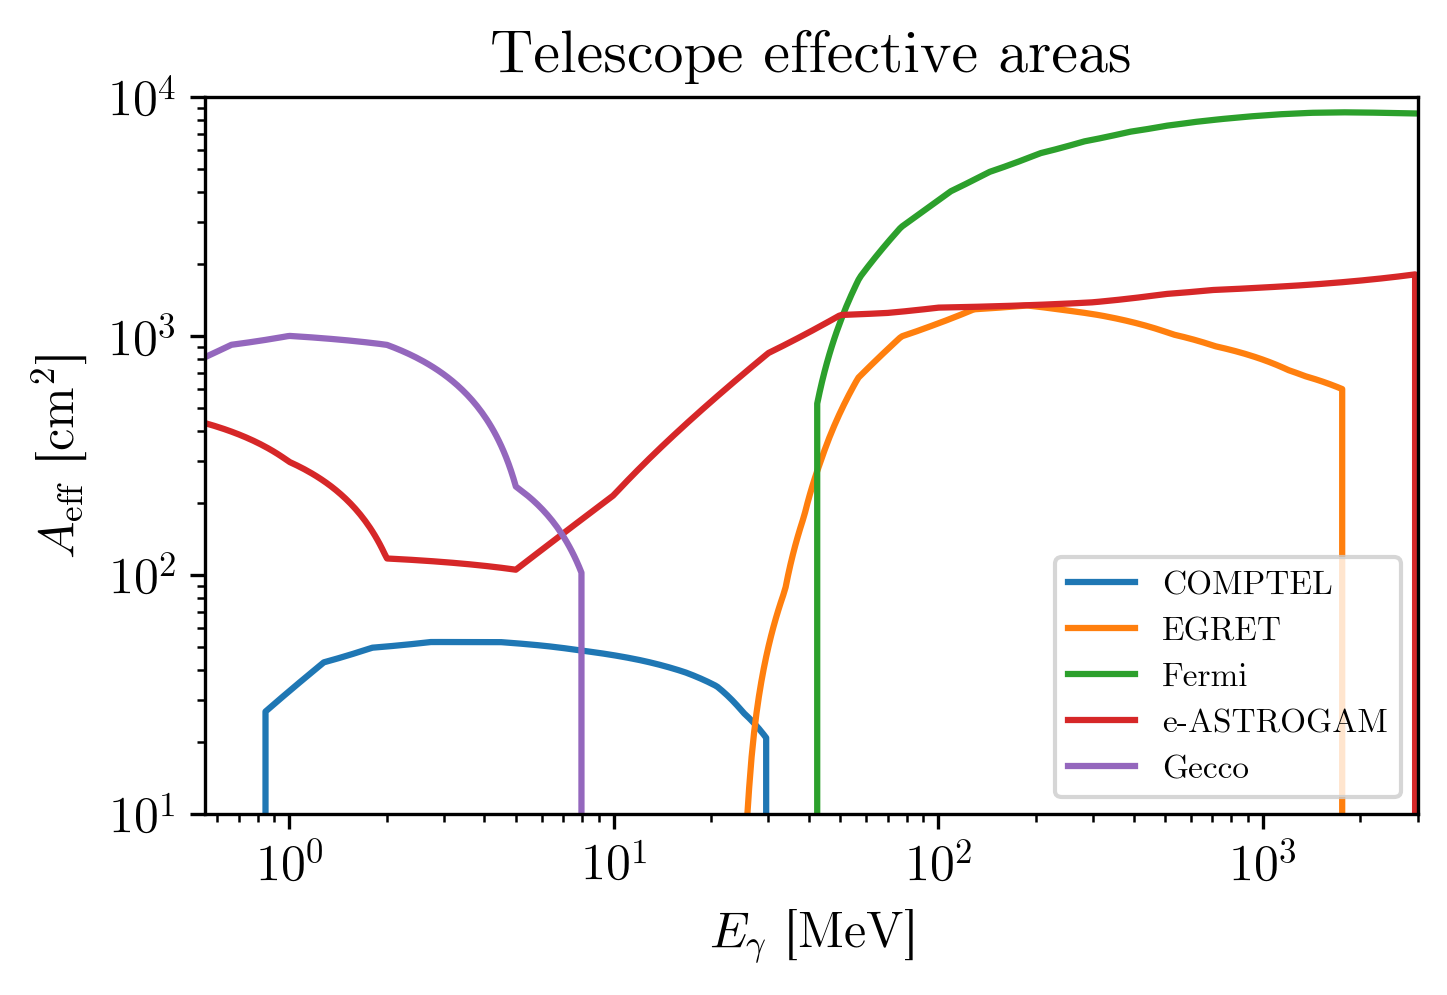

In [68]:
e_gammas = np.geomspace(0.55, 3e3, 500)

plt.plot(e_gammas, A_eff_comptel(e_gammas), label="COMPTEL")
plt.plot(e_gammas, A_eff_egret(e_gammas), label="EGRET")
plt.plot(e_gammas, A_eff_fermi(e_gammas), label="Fermi")
plt.plot(e_gammas, A_eff_e_astrogam(e_gammas), label="e-ASTROGAM")
plt.plot(e_gammas, A_eff_gecco(e_gammas), label="Gecco")

plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$A_\mathrm{eff}$ [cm$^2$]")
plt.xlim(e_gammas[[0, -1]])
plt.ylim(1e1, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=8)
plt.title("Telescope effective areas")

plt.tight_layout()
plt.savefig("figures/gecco/a_eff.png")

# Higgs portal model

In [3]:
from hazma.scalar_mediator import HiggsPortal

In [62]:
stheta = 0.1
hp = HiggsPortal(mx=1., ms=200, gsxx=1., stheta=stheta)

# Masses to scan over
mx_min = 0.55  # a bit larger than m_e
mx_max = 250.
n_mxs = 50
mxs = np.geomspace(mx_min, mx_max, n_mxs)

In [64]:
sv_comptel = np.zeros_like(mxs)
sv_egret = np.zeros_like(mxs)
sv_fermi = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    hp.mx = mx
    sv_comptel[i] = hp.binned_limit(comptel_diffuse)
    sv_egret[i] = hp.binned_limit(egret_diffuse)
    sv_fermi[i] = hp.binned_limit(fermi_diffuse)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


In [65]:
sv_e_astrogam = np.zeros_like(mxs)
sv_gecco = np.zeros_like(mxs)
sv_gecco_large = np.zeros_like(mxs)
sv_comptel_check = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    hp.mx = mx
    sv_e_astrogam[i] = hp.unbinned_limit(
        A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam, gc_target, gc_bg_model
    )
    sv_gecco[i] = hp.unbinned_limit(
        A_eff_gecco, energy_res_gecco, T_obs_gecco, comptel_diffuse.target,
        default_bg_model
    )
    sv_gecco_large[i] = hp.unbinned_limit(
        A_eff_gecco, energy_res_gecco_large, T_obs_gecco, comptel_diffuse.target,
        default_bg_model
    )
    sv_comptel_check[i] = hp.unbinned_limit(
        A_eff_comptel, energy_res_comptel, T_obs_gecco, comptel_diffuse.target,
        default_bg_model
    )

In [66]:
sv_cmb = np.zeros_like(mxs)

for i, mx in enumerate(mxs):
    hp.mx = mx
    sv_cmb[i] = hp.cmb_limit()

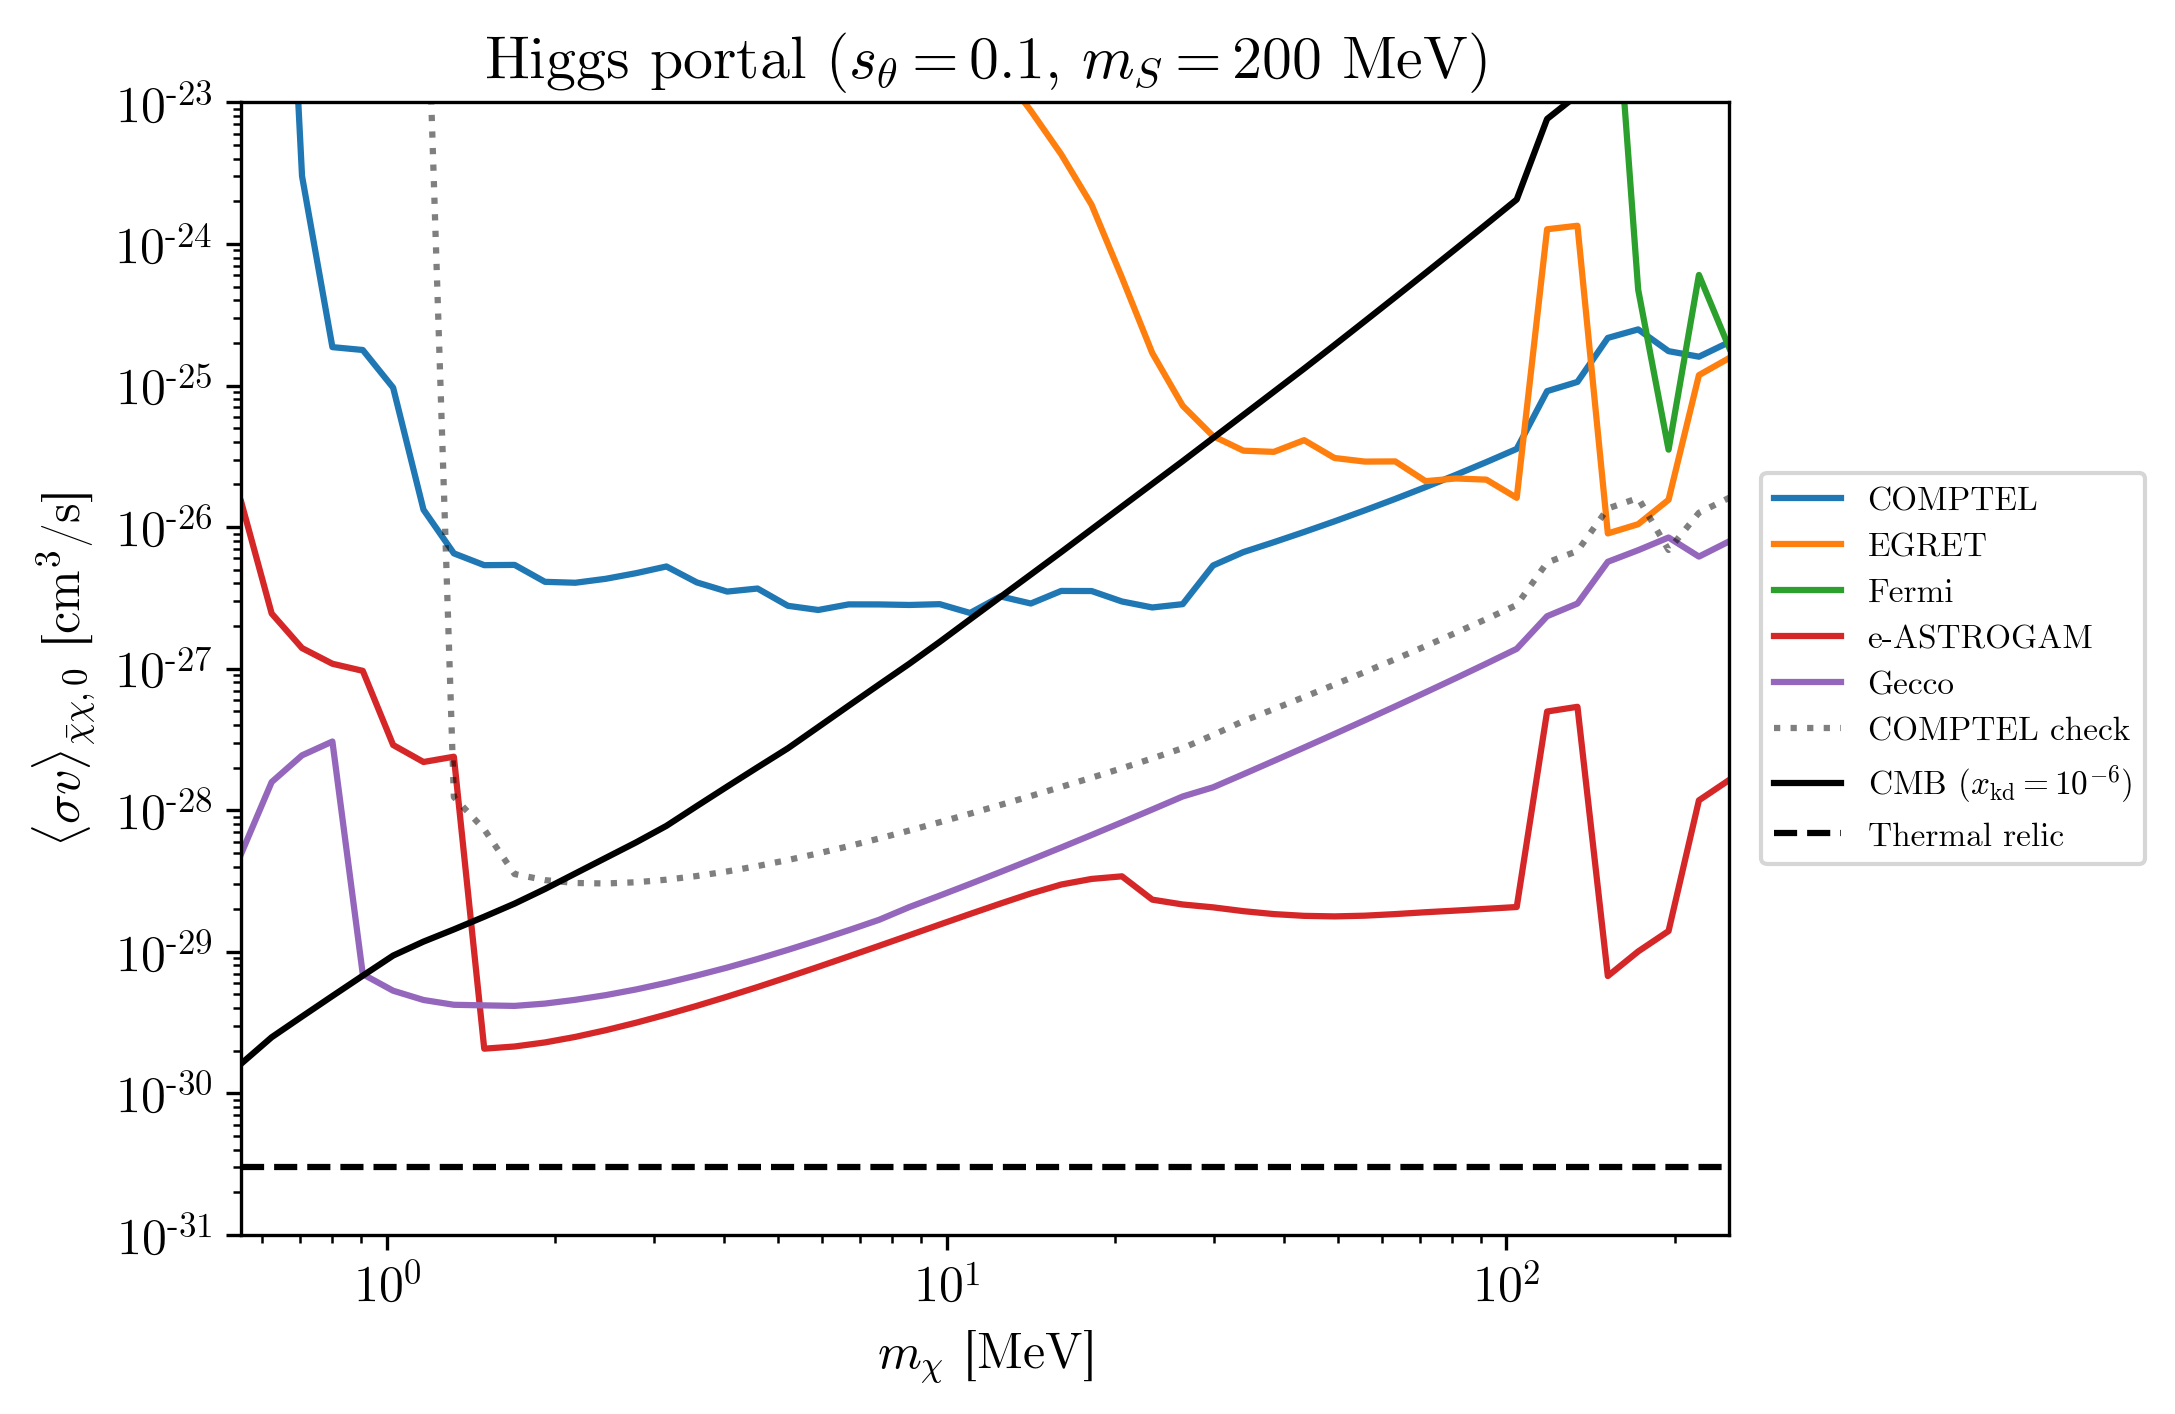

In [67]:
plt.figure(figsize=(8, 5))

# Current constraints
plt.plot(mxs, sv_comptel, label="COMPTEL")
plt.plot(mxs, sv_egret, label="EGRET")
plt.plot(mxs, sv_fermi, label="Fermi")

# Projections
plt.plot(mxs, sv_e_astrogam, label="e-ASTROGAM")
plt.plot(mxs, sv_gecco, label="Gecco")
plt.plot(mxs, sv_comptel_check, ":k", alpha=0.5, label="COMPTEL check")

# CMB bound translated to bound on <sigma v> in the Milky Way
v_mw = 1e-3
x_kd = 1e-6
v_cmbs = 2e-4 * (0.235 / 1) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
plt.plot(mxs, sv_cmb * (v_mw / v_cmbs)**2, "k", label=r"CMB ($x_\mathrm{kd} = 10^{-6}$)")

# Relic cross section tranlated to <sigma v> in the Milky Way
v_fo = np.sqrt(1/10)
plt.axhline(3e-26 * (v_mw / v_fo)**2, linestyle="--", color="k", label="Thermal relic")

plt.xlabel(r"$m_\chi$ [MeV]")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]")
plt.xlim(mxs[[0, -1]])
plt.ylim(1e-31, 1e-23)
plt.xscale("log")
plt.yscale("log")
plt.title("Higgs portal (" + r"$s_\theta = $" + f"{hp.stheta}, " + r"$m_S = $" + f"{hp.ms} MeV)")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))

# plt.tight_layout()
plt.savefig("figures/gecco/sm_m_s=200.png", bbox_inches="tight")